In [1]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
import PIL.Image as Image

from BCS_functions import *


AOI_KEYWORD = "6x6-CROP"
LOW_PASS_KEYWORD = "LP_Filter"
IMG_SUFFIX = ".tif"

img_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\PSA-CIEMAT\data\Test tracking H1605 to BCS people"
img_files = glob(os.path.join(img_folder, "*" + IMG_SUFFIX))

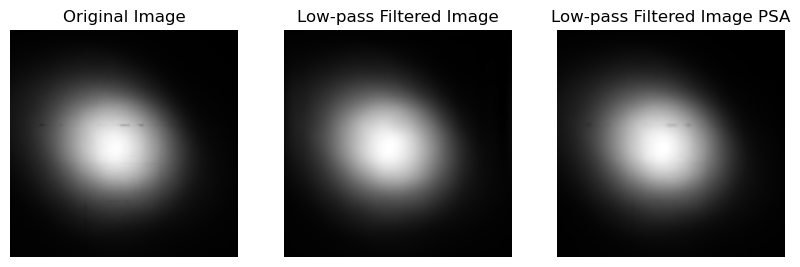

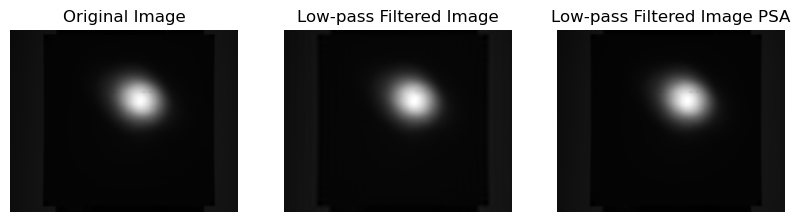

In [2]:
# Test different low pass filter results, choose those from img_files that does not contain LOW_PASS_KEYWORD
img_of_interest = [img for img in img_files if LOW_PASS_KEYWORD not in img ]

fft_low_passed_dict = {}

for img_file in img_of_interest:
    img = Image.open(img_file)
    img = np.array(img)
    img_low_pass = BCS_functions.low_pass_filter(img, keep_ratio=0.05)
    # insert LOW_PASS_KEYWORD into the file name before the suffix
    img_low_pass_PSA = img_file.replace(IMG_SUFFIX, f" {LOW_PASS_KEYWORD}{IMG_SUFFIX}")
    img_low_pass_PSA = np.array(Image.open(img_low_pass_PSA))

    if AOI_KEYWORD in img_file:
        dict_key = "AOI_NREL_LPF"
    else:
        dict_key = "Full_NREL_LPF"

    fft_low_passed_dict[dict_key] = img_low_pass
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(img_low_pass, cmap='gray')
    axs[1].set_title("Low-pass Filtered Image")
    axs[1].axis('off')

    axs[2].imshow(img_low_pass_PSA, cmap='gray')
    axs[2].set_title("Low-pass Filtered Image PSA")
    axs[2].axis('off')
    plt.show()


    



Centroid of the 6x6 cropped image:  (242.49579153695376, 212.25625504439063)
Maximum intensity point:  [248 219]


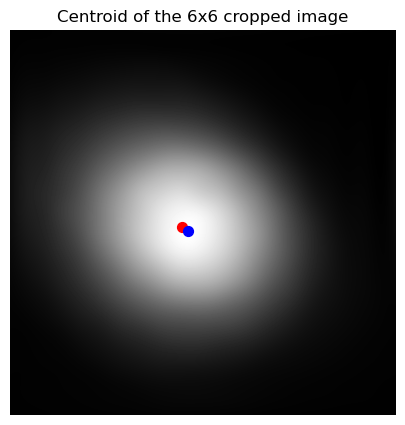

In [3]:
# performing center finding on the 6x6 cropped images
from skimage.measure import label, regionprops
from skimage.filters import threshold_yen
bright_spot_threshold = threshold_yen(fft_low_passed_dict["AOI_NREL_LPF"])
regionprops_list = regionprops(label(fft_low_passed_dict["AOI_NREL_LPF"] > bright_spot_threshold), 
                                intensity_image=fft_low_passed_dict["AOI_NREL_LPF"])
centroid = regionprops_list[0].centroid

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(fft_low_passed_dict["AOI_NREL_LPF"], cmap='gray')
ax.scatter(centroid[1], centroid[0], c='r', s=50)
ax.set_title("Centroid of the 6x6 cropped image")
ax.axis('off')

print("Centroid of the 6x6 cropped image: ", centroid)

# finding the maximum intensity point
from skimage.feature import peak_local_max

max_coord = peak_local_max(fft_low_passed_dict["AOI_NREL_LPF"], min_distance=10, num_peaks=1)[0]
print("Maximum intensity point: ", max_coord)

ax.scatter(max_coord[1], max_coord[0], c='b', s=50)
plt.show()



In [4]:
# tracking error calculation
img_center_x = fft_low_passed_dict["AOI_NREL_LPF"].shape[1] / 2
img_center_y = fft_low_passed_dict["AOI_NREL_LPF"].shape[0] / 2

scaling_factor_x = 6 / fft_low_passed_dict["AOI_NREL_LPF"].shape[1]
scaling_factor_y = 6 / fft_low_passed_dict["AOI_NREL_LPF"].shape[0]
img_center_x_meter = (centroid[1] - img_center_x) * scaling_factor_x
img_center_y_meter = (img_center_y - centroid[0]) * scaling_factor_y

target_center = np.array([-0.008, 6.524, 34.165])
aiming_point = target_center + np.array([-1, 0, 1.5])
beam_center = aiming_point + np.array([-1*img_center_x_meter, 0, img_center_y_meter])
camera_position = np.array([0, 297.69, 5.26])

aiming_point_vector = aiming_point - camera_position
beam_center_vector = beam_center - camera_position

# calculate the tracking error with dot product
aiming_vector_norm = np.linalg.norm(aiming_point_vector)
beam_vector_norm = np.linalg.norm(beam_center_vector)
tracking_error = np.arccos(np.dot(aiming_point_vector, beam_center_vector) / (aiming_vector_norm * beam_vector_norm))

tracking_error_mrad = tracking_error * 1000
print("Tracking error in mrad: ", tracking_error_mrad)

beam_center_elevation_only = aiming_point + np.array([0, 0, img_center_y_meter])
beam_center_vector_elevation_only = beam_center_elevation_only - camera_position
beam_vector_elevation_only_norm = np.linalg.norm(beam_center_vector_elevation_only)
tracking_error_elevation_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_elevation_only) / (aiming_vector_norm * beam_vector_elevation_only_norm))
tracking_error_elevation_only_mrad = tracking_error_elevation_only * 1000
print("Tracking error in mrad (elevation only): ", tracking_error_elevation_only_mrad)

beam_center_azimuth_only = aiming_point + np.array([-1*img_center_x_meter, 0, 0])
beam_center_vector_azimuth_only = beam_center_azimuth_only - camera_position
beam_vector_azimuth_only_norm = np.linalg.norm(beam_center_vector_azimuth_only)
tracking_error_azimuth_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_azimuth_only) / (aiming_vector_norm * beam_vector_azimuth_only_norm))
tracking_error_azimuth_only_mrad = tracking_error_azimuth_only * 1000
print("Tracking error in mrad (azimuth only): ", tracking_error_azimuth_only_mrad)



Tracking error in mrad:  1.1438840822456413
Tracking error in mrad (elevation only):  0.19253328583250848
Tracking error in mrad (azimuth only):  1.1276109696722083


Centroid of the full image:  (401.0, 732.0)
Maximum intensity point:  [401 732]


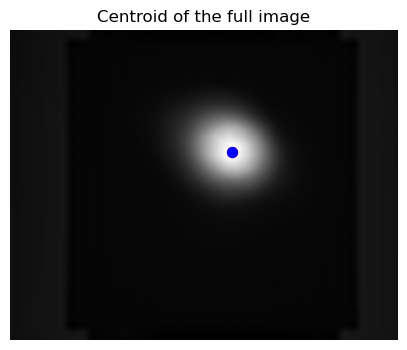

In [5]:
# find centroid on the full image
bright_spot_threshold = threshold_yen(fft_low_passed_dict["Full_NREL_LPF"])
regionprops_list = regionprops(label(fft_low_passed_dict["Full_NREL_LPF"] > bright_spot_threshold), 
                                intensity_image=fft_low_passed_dict["Full_NREL_LPF"])
centroid = regionprops_list[0].centroid

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(fft_low_passed_dict["Full_NREL_LPF"], cmap='gray')
ax.scatter(centroid[1], centroid[0], c='r', s=50)
ax.set_title("Centroid of the full image")
ax.axis('off')

print("Centroid of the full image: ", centroid)

# finding the maximum intensity point
max_coord = peak_local_max(fft_low_passed_dict["Full_NREL_LPF"], min_distance=10, num_peaks=1)[0]
print("Maximum intensity point: ", max_coord)

ax.scatter(max_coord[1], max_coord[0], c='b', s=50)
plt.show()

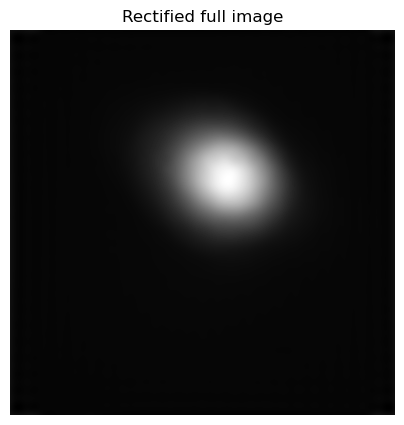

In [6]:
# tracking error calculation
from skimage import transform
src_pts = np.array([[186, 27], [1150, 28], [1149, 991], [183, 993]])
desired_width = 1000
dst = np.array([[0, 0], [desired_width, 0], [desired_width, desired_width], [0, desired_width]])
tform = transform.estimate_transform('projective', dst, src_pts)
rectified = transform.warp(fft_low_passed_dict["Full_NREL_LPF"], tform, output_shape=(desired_width, desired_width))

# visualize
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(rectified, cmap='gray')
ax.set_title("Rectified full image")
ax.axis('off')
plt.show()

Centroid of the rectified full image:  (381.21991275757676, 557.4832188547804)
Maximum intensity point:  [388 566]


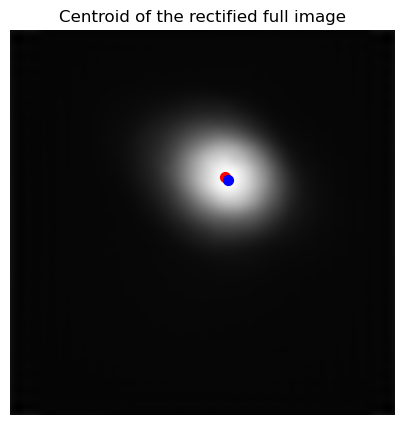

Tracking error in mrad:  1.0894659408562193
Tracking error in mrad (elevation only):  0.2535850592067049
Tracking error in mrad (azimuth only):  1.0596056099535522


In [7]:
# tracking error estimation on rectified
bright_spot_threshold = threshold_yen(rectified)
regionprops_list = regionprops(label(rectified > bright_spot_threshold), 
                                intensity_image=rectified)
centroid = regionprops_list[0].centroid

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(rectified, cmap='gray')
ax.scatter(centroid[1], centroid[0], c='r', s=50)
ax.set_title("Centroid of the rectified full image")
ax.axis('off')

print("Centroid of the rectified full image: ", centroid)

# finding the maximum intensity point
max_coord = peak_local_max(rectified, min_distance=10, num_peaks=1)[0]
print("Maximum intensity point: ", max_coord)

ax.scatter(max_coord[1], max_coord[0], c='b', s=50)
plt.show()

# tracking error calculation

img_center_x = rectified.shape[1] / 2 + rectified.shape[1] / 12 # pointing center is 1m to the right
img_center_y = rectified.shape[0] / 2 - (rectified.shape[0] * 1.5) / 12 # pointing center is 1.5m to the top

scaling_factor_x = 12 / rectified.shape[1]
scaling_factor_y = 12 / rectified.shape[0]

img_center_x_meter = (centroid[1] - img_center_x) * scaling_factor_x
img_center_y_meter = (img_center_y - centroid[0]) * scaling_factor_y

target_center = np.array([-0.008, 6.524, 34.165])
aiming_point = target_center + np.array([-1, 0, 1.5])
beam_center = aiming_point + np.array([-1*img_center_x_meter, 0, img_center_y_meter])
camera_position = np.array([0, 297.69, 5.26])

aiming_point_vector = aiming_point - camera_position
beam_center_vector = beam_center - camera_position

# calculate the tracking error with dot product
aiming_vector_norm = np.linalg.norm(aiming_point_vector)
beam_vector_norm = np.linalg.norm(beam_center_vector)

tracking_error = np.arccos(np.dot(aiming_point_vector, beam_center_vector) / (aiming_vector_norm * beam_vector_norm))
tracking_error_mrad = tracking_error * 1000
print("Tracking error in mrad: ", tracking_error_mrad)

beam_center_elevation_only = aiming_point + np.array([0, 0, img_center_y_meter])
beam_center_vector_elevation_only = beam_center_elevation_only - camera_position
beam_vector_elevation_only_norm = np.linalg.norm(beam_center_vector_elevation_only)

tracking_error_elevation_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_elevation_only) / (aiming_vector_norm * beam_vector_elevation_only_norm))
tracking_error_elevation_only_mrad = tracking_error_elevation_only * 1000
print("Tracking error in mrad (elevation only): ", tracking_error_elevation_only_mrad)

beam_center_azimuth_only = aiming_point + np.array([-1*img_center_x_meter, 0, 0])
beam_center_vector_azimuth_only = beam_center_azimuth_only - camera_position
beam_vector_azimuth_only_norm = np.linalg.norm(beam_center_vector_azimuth_only)

tracking_error_azimuth_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_azimuth_only) / (aiming_vector_norm * beam_vector_azimuth_only_norm))
tracking_error_azimuth_only_mrad = tracking_error_azimuth_only * 1000
print("Tracking error in mrad (azimuth only): ", tracking_error_azimuth_only_mrad)

